In [1]:
# set working directory to project root
import os
os.chdir("..")
# imports
from scripts.preprocess import DataHandler
import torch
from torch.utils.data import TensorDataset, DataLoader
from scripts.multilayer_perceptrons import BaselineMLP, DeepFeatureMLP, CompactBatchnormMLP
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

#### Preprocessing data:

In [2]:
# read in data
data_handler = DataHandler()
data_handler.load_data_into_class(file_path="data/project_adult.csv")

# split into train and test
X_train, X_test, y_train, y_test = data_handler.split_data(target_column="income", filepath="data/project_adult.csv" ,test_size=0.2)

# preprocess the data
X_train_processed = data_handler.preprocess_set(X_train, train_or_test="train").to_numpy()
X_test_processed = data_handler.preprocess_set(X_test, train_or_test="test").to_numpy()
label_map = {"<=50K": 0, ">50K": 1}
y_train = y_train.map(label_map).to_numpy()
y_test = y_test.map(label_map).to_numpy()

# convert to tensors and build train data set
X_train_processed = torch.from_numpy(X_train_processed).float()
X_test_processed = torch.from_numpy(X_test_processed).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()
train_dataset = TensorDataset(X_train_processed, y_train)

# set default training device to GPU if available
try:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✅ Using Apple Metal (MPS) backend.")
        device_use = True
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
        device_use = True
    else:
        raise RuntimeError("No GPU backend found.")
except Exception as e:
    print(f"⚠️ GPU not available or error occurred: {e}")
    device = torch.device("cpu")
    device_use = False
    print("🖥️ Using CPU instead.")


device = select_training_device()
device_use = device.type != "cpu"
print(f"Active device: {device}")

# set seed, set batch size, and initializes dataloader
torch.manual_seed(1)
if device_use:
    batch_size = 128
else:
    batch_size = 2
train_dataloader_baseline_mlp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

✅ Using Apple Metal (MPS) backend.
Active device: mps


#### Training Baseline MLP:


Epoch [1/45] - Loss: 0.4291, Accuracy: 0.7711
Epoch [2/45] - Loss: 0.3250, Accuracy: 0.8497
Epoch [3/45] - Loss: 0.3162, Accuracy: 0.8542
Epoch [4/45] - Loss: 0.3137, Accuracy: 0.8552
Epoch [5/45] - Loss: 0.3098, Accuracy: 0.8573
Epoch [6/45] - Loss: 0.3073, Accuracy: 0.8582
Epoch [7/45] - Loss: 0.3074, Accuracy: 0.8590
Epoch [8/45] - Loss: 0.3043, Accuracy: 0.8611
Epoch [9/45] - Loss: 0.3050, Accuracy: 0.8593
Epoch [10/45] - Loss: 0.3038, Accuracy: 0.8613
Epoch [11/45] - Loss: 0.3028, Accuracy: 0.8605
Epoch [12/45] - Loss: 0.3006, Accuracy: 0.8637
Epoch [13/45] - Loss: 0.2995, Accuracy: 0.8625
Epoch [14/45] - Loss: 0.2999, Accuracy: 0.8629
Epoch [15/45] - Loss: 0.2984, Accuracy: 0.8632
Epoch [16/45] - Loss: 0.2969, Accuracy: 0.8659
Epoch [17/45] - Loss: 0.2961, Accuracy: 0.8647
Epoch [18/45] - Loss: 0.2951, Accuracy: 0.8676
Epoch [19/45] - Loss: 0.2955, Accuracy: 0.8672
Epoch [20/45] - Loss: 0.2945, Accuracy: 0.8664
Epoch [21/45] - Loss: 0.2924, Accuracy: 0.8676
Epoch [22/45] - Loss: 

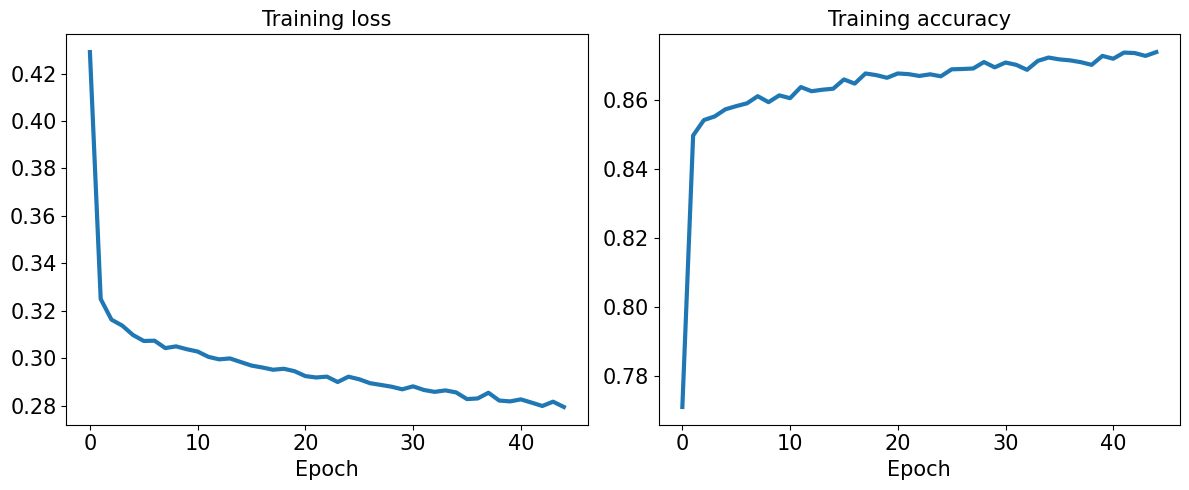

In [3]:
# initialize baseline MLP with 64 nodes in the first hidden layer and 32 in the second hidden layer
baseline_mlp = BaselineMLP(input_size=X_train_processed.shape[1], output_size=2)
if device_use:
    baseline_mlp.to(device)

# initialize loss, learning rate, and optimizer for training loop, and setting baseline mlp to train mode some dropout works
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_mlp.parameters(), lr=learning_rate, weight_decay=1e-4)
baseline_mlp.train()

# build and execute training loop
num_epochs = 45
loss_history = [0] * num_epochs
accuracy_history = [0] * num_epochs

for epoch in range(num_epochs):
    running_loss, running_correct, total = 0.0, 0, 0

    # load data
    for x_batch, y_batch in train_dataloader_baseline_mlp:
        # use GPU device if available
        if device_use:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = baseline_mlp(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # compute running loss
        running_loss += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().item()
        running_correct += is_correct
        total += y_batch.size(0)

    # store loss history
    loss_history[epoch] = running_loss / total
    accuracy_history[epoch] = running_correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss_history[epoch]:.4f}, "f"Accuracy: {accuracy_history[epoch]:.4f}")

# plot results
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

#### Evaluate performance of BaselineMLP:

In [4]:
# get predictions on the test set
if device_use:
    X_test_processed = X_test_processed.to(device)
    y_test = y_test.to(device)

baseline_mlp.eval() # switch to evaluation mode (we use dropout!)
with torch.no_grad(): # don't track graphs for prediction
    predictions_test = baseline_mlp(X_test_processed)

# evaluate predictions
correct = (torch.argmax(predictions_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f"Test Accuracy of our BaselineMLP: {accuracy:.4f}")

Test Accuracy of our BaselineMLP: 0.8526


#### Training DeepFeatureMLP:

Epoch [1/35] - Loss: 0.3869, Accuracy: 0.8191
Epoch [2/35] - Loss: 0.3201, Accuracy: 0.8518
Epoch [3/35] - Loss: 0.3155, Accuracy: 0.8560
Epoch [4/35] - Loss: 0.3138, Accuracy: 0.8549
Epoch [5/35] - Loss: 0.3118, Accuracy: 0.8576
Epoch [6/35] - Loss: 0.3122, Accuracy: 0.8558
Epoch [7/35] - Loss: 0.3090, Accuracy: 0.8576
Epoch [8/35] - Loss: 0.3090, Accuracy: 0.8597
Epoch [9/35] - Loss: 0.3095, Accuracy: 0.8598
Epoch [10/35] - Loss: 0.3085, Accuracy: 0.8581
Epoch [11/35] - Loss: 0.3065, Accuracy: 0.8598
Epoch [12/35] - Loss: 0.3064, Accuracy: 0.8592
Epoch [13/35] - Loss: 0.3041, Accuracy: 0.8602
Epoch [14/35] - Loss: 0.3049, Accuracy: 0.8604
Epoch [15/35] - Loss: 0.3055, Accuracy: 0.8612
Epoch [16/35] - Loss: 0.3035, Accuracy: 0.8628
Epoch [17/35] - Loss: 0.3034, Accuracy: 0.8618
Epoch [18/35] - Loss: 0.3038, Accuracy: 0.8630
Epoch [19/35] - Loss: 0.3025, Accuracy: 0.8628
Epoch [20/35] - Loss: 0.3015, Accuracy: 0.8637
Epoch [21/35] - Loss: 0.3026, Accuracy: 0.8632
Epoch [22/35] - Loss: 

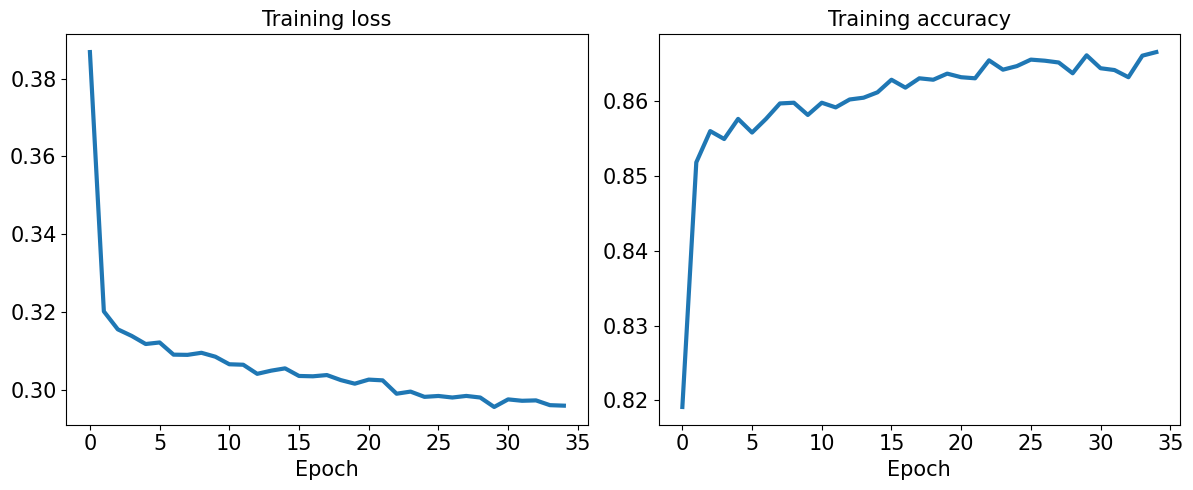

In [5]:
# reload dataloader
train_dataloader_deep_mlp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# initialize deep MLP with 64 nodes in the first hidden layer and 32 in the second hidden layer
deep_mlp = DeepFeatureMLP(input_size=X_train_processed.shape[1], output_size=2)
if device_use:
    deep_mlp.to(device)

# initialize loss, learning rate, and optimizer for training loop, and setting deep mlp to train mode some dropout works
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_mlp.parameters(), lr=learning_rate, weight_decay=1e-3)
deep_mlp.train()

# build and execute training loop
num_epochs = 35
loss_history = [0] * num_epochs
accuracy_history = [0] * num_epochs

for epoch in range(num_epochs):
    running_loss, running_correct, total = 0.0, 0, 0

    # load data
    for x_batch, y_batch in train_dataloader_deep_mlp:
        # use GPU device if available
        if device_use:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = deep_mlp(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # compute running loss
        running_loss += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().item()
        running_correct += is_correct
        total += y_batch.size(0)

    # store loss history
    loss_history[epoch] = running_loss / total
    accuracy_history[epoch] = running_correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss_history[epoch]:.4f}, "f"Accuracy: {accuracy_history[epoch]:.4f}")

# plot results
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

#### Evaluate performance of DeepMLP:

In [6]:
# get predictions on the test set
if device_use:
    X_test_processed = X_test_processed.to(device)
    y_test = y_test.to(device)

baseline_mlp.eval() # switch to evaluation mode (we use dropout!)
with torch.no_grad(): # don't track graphs for prediction
    predictions_test = deep_mlp(X_test_processed)

# evaluate predictions
correct = (torch.argmax(predictions_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f"Test Accuracy of our DeepMLP: {accuracy:.4f}")

Test Accuracy of our DeepMLP: 0.8501


#### Training CompactBatchnormMLP:

Epoch [1/45] - Loss: 0.3834, Accuracy: 0.8225
Epoch [2/45] - Loss: 0.3140, Accuracy: 0.8567
Epoch [3/45] - Loss: 0.3074, Accuracy: 0.8580
Epoch [4/45] - Loss: 0.3016, Accuracy: 0.8596
Epoch [5/45] - Loss: 0.2979, Accuracy: 0.8611
Epoch [6/45] - Loss: 0.2954, Accuracy: 0.8606
Epoch [7/45] - Loss: 0.2931, Accuracy: 0.8640
Epoch [8/45] - Loss: 0.2890, Accuracy: 0.8641
Epoch [9/45] - Loss: 0.2874, Accuracy: 0.8665
Epoch [10/45] - Loss: 0.2848, Accuracy: 0.8665
Epoch [11/45] - Loss: 0.2817, Accuracy: 0.8698
Epoch [12/45] - Loss: 0.2790, Accuracy: 0.8707
Epoch [13/45] - Loss: 0.2783, Accuracy: 0.8702
Epoch [14/45] - Loss: 0.2773, Accuracy: 0.8719
Epoch [15/45] - Loss: 0.2761, Accuracy: 0.8706
Epoch [16/45] - Loss: 0.2730, Accuracy: 0.8731
Epoch [17/45] - Loss: 0.2708, Accuracy: 0.8735
Epoch [18/45] - Loss: 0.2695, Accuracy: 0.8748
Epoch [19/45] - Loss: 0.2670, Accuracy: 0.8771
Epoch [20/45] - Loss: 0.2635, Accuracy: 0.8775
Epoch [21/45] - Loss: 0.2649, Accuracy: 0.8761
Epoch [22/45] - Loss: 

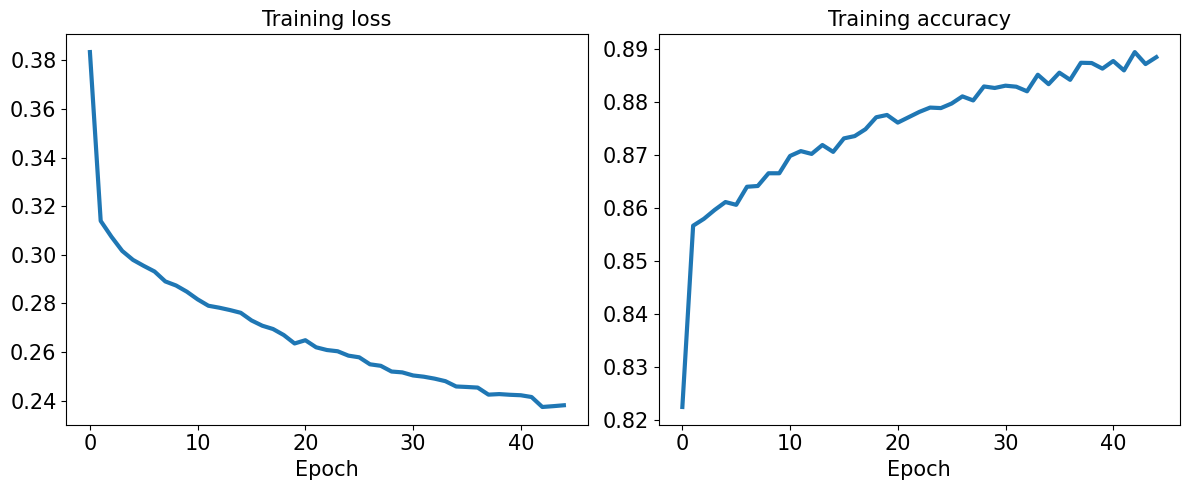

In [7]:
# reload dataloader
train_dataloader_compact_mlp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# initialize deep MLP with 64 nodes in the first hidden layer and 32 in the second hidden layer
compact_mlp = CompactBatchnormMLP(input_size=X_train_processed.shape[1], output_size=2)
compact_mlp.to(device)

# initialize loss, learning rate, and optimizer for training loop, and setting deep mlp to train mode some dropout works
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(compact_mlp.parameters(), lr=learning_rate, weight_decay=1e-3)
compact_mlp.train()

# build and execute training loop
num_epochs = 45
loss_history = [0] * num_epochs
accuracy_history = [0] * num_epochs

for epoch in range(num_epochs):
    running_loss, running_correct, total = 0.0, 0, 0

    # load data
    for x_batch, y_batch in train_dataloader_compact_mlp:
        # use GPU device if available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = compact_mlp(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # compute running loss
        running_loss += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().item()
        running_correct += is_correct
        total += y_batch.size(0)

    # store loss history
    loss_history[epoch] = running_loss / total
    accuracy_history[epoch] = running_correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss_history[epoch]:.4f}, "f"Accuracy: {accuracy_history[epoch]:.4f}")

# plot results
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

#### Evaluate performance of CompactBatchnormMLP:

In [8]:
# get predictions on the test set
X_test_processed = X_test_processed.to(device)
y_test = y_test.to(device)

compact_mlp.eval() # switch to evaluation mode (we use dropout!)
with torch.no_grad(): # don't track graphs for prediction
    predictions_test = compact_mlp(X_test_processed)

# evaluate predictions
correct = (torch.argmax(predictions_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f"Test Accuracy of our CompactMLP: {accuracy:.4f}")

Test Accuracy of our CompactMLP: 0.8374


#### Choose our best model:

In [9]:
# load in validation set
data_handler.load_data_into_class(file_path="data/project_validation_inputs.csv")
X_validation_set = data_handler.pop_dataset_from_class(file_path="data/project_validation_inputs.csv")

# preprocess set
X_processed_validation = data_handler.preprocess_set(X_validation_set, train_or_test="test").to_numpy()

# load into tensor
X_processed_validation = torch.from_numpy(X_processed_validation).float()
X_processed_validation = X_processed_validation.to(device)

# predict using evaluation mode of baselineMLP
baseline_mlp.eval()
with torch.no_grad():
    predictions_validation = baseline_mlp(X_processed_validation)

# convert predictions into 0's and 1's
predictions_validation = torch.argmax(predictions_validation, dim=1)

# convert 0's into -1
predictions_validation = predictions_validation.detach().cpu().numpy()
predictions_validation[predictions_validation == 0] = -1

# send to csv
np.savetxt(fname="outputs/Group_27_MLP_PredictedOutputs.csv", X=predictions_validation, delimiter=",", fmt="%d")